# Adversarial Reinforcement Learning

subfield of RL designed to train policies that are robust to adversarial conditions, disturbances, and uncertainty. Unlike traditional RL, where environments are typically static or flowwo predictable distributions, adversarial RL considers scenarios where an adversary deliberately tries to deceive, distract or mislead the learning agent.
In real-world environments, perfect knowledge and ideal conditions rarely exist, an RL agent might encounter sensor noise and inaccuracies, unexpected environment dynamics and malicious actor actively attemputing to compromise the agent's performance. Training on adversarial scenarios helps them generalize better, becoming robust,reliable and safe.

## Background

Adversarual RL extends traditional RL by introducing an adversary (also called "disturbance agent" or "adversarial policy") whose goal is to minimize the reward of the primary agent and introduce worse-case scenarios intentionally, pushing the primary agent to learn more roust strategies.
The Main components of adversarial RL are:
- **Protagonist**(Primary Agent): Attempts to maximize its reward by learning a policy that can perform well in the presence of adversarial disturbances.
- **Adversary**(Advresarial Agent): Attempts to minimize the reward of the protagonist by introducing disturbances or perturbations to the environment.

## Theory

Adversarial RL can be seen as solving a two-player zero-sum game. Formally we consider an MDP defined as:
- State space $S$
- Action space $A$
- Adversarial action space $U$
- Transition dynamics $P(s'|s,a, u)$
- Reward function $R(s,a,u)$
The optimization objective becomes a mimimax problem:
$$\max_{\pi_\theta}\min_{pi_\phi} \mathbb{E} [\sum_{t=0}^{\infty}\gamma^t r(s_t, a_t, u_t)]$$
Where:
- $\pi_\theta$ is the policy of the protagonist
- $\pi_\phi$ is the policy of the adversary
- $r(s_t, a_t, u_t)$ is the reward function
- $\gamma$ is the discount factor

## Mathematical Formulation

Let:
- $\pi_\theta(a|s)$ be the policy of the protagonist parameterized by $\theta$
- $\pi_\phi(u|s)$ be the policy of the adversary parameterized by $\phi$
The value function in an adversarial context becomes the minimax value function:
$$V^{\pi_\theta,\pi_\phi}(s) = \mathbb{E}[\sum_{t=0}^{\infty}\gamma^t r(s_t, a_t, u_t) | s_0 = s, a_t \sim \pi_\theta(a|s_t), u_t \sim \pi_\phi(u|s_t)]$$
The minimax optimal policy is computed as:
$$\pi^*_\theta = \arg\max_{\pi_\theta} \min_{\pi_\phi} V^{\pi_\theta,\pi_\phi}(s)$$
The adversary simultaneously seeks:
$$\pi^*_\phi = \arg\min_{\pi_\phi} V^{\pi_\theta,\pi_\phi}(s)$$

The general training scheme iteratively solves a minimax game:
1. Protagonist update:
$$\theta \leftarrow \theta + \alpha_\theta \nabla_\theta V^{\pi_\theta,\pi_\phi}(s)$$
2. Adversary update:
$$\phi \leftarrow \phi - \alpha_\phi \nabla_\phi V^{\pi_\theta,\pi_\phi}(s)$$
Similar to Generative Adversarial Networks but adapted for RL.

## Implementation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128), nn.ReLU(),
            nn.Linear(128, act_dim), nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class AdversarialAgent:
    def __init__(self, obs_dim, act_dim):
        self.actor = Actor(obs_dim, act_dim).to(device)
        self.critic = Critic(obs_dim).to(device)

        self.adversary = Actor(obs_dim, act_dim).to(device)

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.adversary_optim = optim.Adam(self.adversary.parameters(), lr=1e-3)

    def select_action(self, obs):
        state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        action = self.actor(state)
        return action.cpu().detach().numpy()[0]
    
    def select_adversarial_action(self, obs):
        state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        action = self.adversary(state)
        return action.cpu().detach().numpy()[0]
    
    def update(self, state, acton, adv_action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
        action = torch.tensor(acton, dtype=torch.float32).unsqueeze(0).to(device)
        adv_action = torch.tensor(adv_action, dtype=torch.float32).unsqueeze(0).to(device)
        reward = torch.tensor([reward], dtype=torch.float32).to(device)
        done = torch.tensor([done], dtype=torch.float32).to(device)

        target = reward + (1-done) * self.critic(next_state) * 0.99
        critic_loss = nn.functional.mse_loss(self.critic(state), target.detach())
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        actor_loss = -self.critic(state).mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        adv_loss = self.critic(state).mean()
        self.adversary_optim.zero_grad()
        adv_loss.backward()
        self.adversary_optim.step()

Episode: 0, Reward: -1676.3489585899285
Episode: 10, Reward: -1773.4060905838562
Episode: 20, Reward: -1071.1182137771543
Episode: 30, Reward: -1576.5271136051874
Episode: 40, Reward: -1271.779120733714
Episode: 50, Reward: -1347.6627652290974
Episode: 60, Reward: -1120.5790176693906
Episode: 70, Reward: -1331.5487112451774
Episode: 80, Reward: -1728.6105062371496
Episode: 90, Reward: -1329.2279054969647
Episode: 100, Reward: -1431.5643013394813
Episode: 110, Reward: -1575.1291280136559
Episode: 120, Reward: -1197.5659828038356
Episode: 130, Reward: -1315.0775416679232
Episode: 140, Reward: -1325.9587353181023
Episode: 150, Reward: -862.7948602036139
Episode: 160, Reward: -1491.9732736909107
Episode: 170, Reward: -1344.9335411008465
Episode: 180, Reward: -1172.5271572425236
Episode: 190, Reward: -949.536672963668


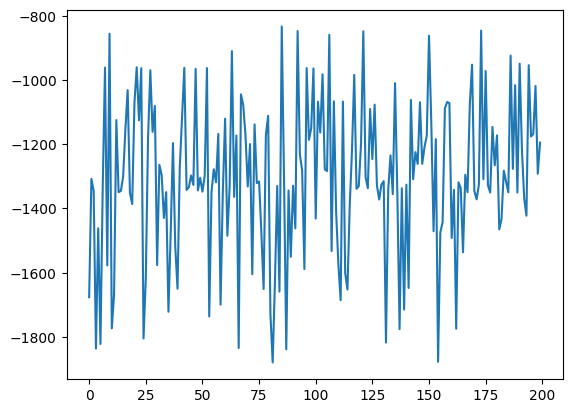

In [5]:
env = gym.make("Pendulum-v1")
agent = AdversarialAgent(env.observation_space.shape[0], env.action_space.shape[0])
num_episodes = 200
rewards = []

for ep in range(num_episodes):
    state, _ = env.reset()
    ep_reward = 0

    for step in range(200):
        action = agent.select_action(state)
        adv_action = agent.select_adversarial_action(state)

        combined_action = np.clip(action + 0.2 * adv_action, -1, 1)
        next_state, reward, terminated, truncated, _ = env.step(combined_action)
        done = terminated or truncated

        agent.update(state, action, adv_action, reward, next_state, done)
        state = next_state
        ep_reward += reward
        if done: break

    rewards.append(ep_reward)
    if ep % 10 == 0:
        print(f"Episode: {ep}, Reward: {ep_reward}")

plt.plot(rewards)
plt.show()
env.close()

## Next Steps

### Integrate with DreamerV2

In [9]:
class IntrinsicReward(nn.Module):
    def __init__(self, latent_dim, intrinsic_scale=0.1):
        super().__init__()
        self.intrinsic_scale = intrinsic_scale
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, z_pred, z_next):
        error = (z_next - z_pred)**2  # shape: [batch_size, latent_dim]
        intrinsic_reward = self.fc(error)  # Now correctly shaped
        return self.intrinsic_scale * intrinsic_reward

In [10]:
class ConvEncoder(nn.Module):
    def __init__(self, image_shape, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), nn.ReLU(),
        )

        dummy_input = torch.zeros(1, *image_shape)
        with torch.no_grad():
            flat_dim = self.encoder(dummy_input).view(1, -1).shape[1]

        # This line fixes the error:
        self.fc = nn.Linear(flat_dim, latent_dim)

    def forward(self, x):
        x = x / 255.0
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [11]:
class RSSM(nn.Module):
    def __init__(self, latent_dim, action_dim):
        super().__init__()
        self.gru = nn.GRUCell(latent_dim + action_dim, latent_dim)
        self.mu_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)

    def forward(self, h, z, a):
        if a.dim() == 1:
            a = a.unsqueeze(0)
        if h.dim() == 1:
            h = h.unsqueeze(0)

        x = torch.cat([z, a], dim=-1)
        h_next = self.gru(x, h)
        mu, logvar = self.mu_layer(h_next), self.logvar_layer(h_next)
        z_next = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)

        return h_next, z_next, mu, logvar

In [12]:
class AdverarialRSSM(nn.Module):
    def __init__(self, latent_dim, action_dim):
        super().__init__()
        self.rssm = RSSM(latent_dim, action_dim)
        self.adversary = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, action_dim), nn.Tanh()
        )

    def forward(self, h,z,a,adversarial=False):
        h_next, z_next, mu, logvar = self.rssm(h,z,a)
        if adversarial:
            perturbation = self.adversary(z_next)
            z_next_adv = z_next + 0.1* perturbation
            return h_next, z_next_adv, mu, logvar
        return h_next, z_next, mu, logvar

In [16]:
class AdversarialDreamerV2Agent:

    def __init__(self, image_shape, action_dim, latent_dim=32):
        self.image_shape = image_shape
        self.action_dim = action_dim
        self.latent_dim = latent_dim
        self.encoder = ConvEncoder(image_shape, latent_dim).to(device)
        self.rssm = AdverarialRSSM(latent_dim, action_dim).to(device)
        self.actor = Actor(latent_dim, action_dim).to(device)
        self.critic = Critic(latent_dim).to(device)
        self.intrinsic_reward = IntrinsicReward(latent_dim).to(device)

        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)

    def parameters(self):
        return list(self.encoder.parameters()) + list(self.rssm.parameters()) + list(self.actor.parameters()) + list(self.critic.parameters()) + list(self.intrinsic_reward.parameters())
    def clone(self):
        clone = AdversarialDreamerV2Agent(self.image_shape, self.action_dim, self.latent_dim)
        clone.load_state_dict(self.state_dict())
        return clone
    def state_dict(self):
        return {
            'encoder': self.encoder.state_dict(),
            'rssm': self.rssm.state_dict(),
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'intrinsic_reward': self.intrinsic_reward.state_dict()
        }
    
    def load_state_dict(self, state_dict):
        self.encoder.load_state_dict(state_dict['encoder'])
        self.rssm.load_state_dict(state_dict['rssm'])
        self.actor.load_state_dict(state_dict['actor'])
        self.critic.load_state_dict(state_dict['critic'])
        self.intrinsic_reward.load_state_dict(state_dict['intrinsic_reward'])

    def adapt(self, obs_seq, action_seq, reward_seq, steps=1, lr=1e-3):
        adapted = self.clone()
        optimizer = optim.Adam(adapted.parameters(), lr=lr)

        for _ in range(steps):
            loss = adapted.compute_adversarial_loss(obs_seq, action_seq, reward_seq)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return adapted
    
    def compute_adversarial_loss(self, obs_seq, action_seq, reward_seq):
        z = self.encoder(obs_seq[0])
        h = torch.zeros_like(z).to(device)

        total_loss = 0.0
        for t in range(len(action_seq)):
            h, z_pred, _, _ = self.rssm(h, z, action_seq[t], adversarial=False)
            z_next = self.encoder(obs_seq[t + 1])

            prediction_loss = ((z_next - z_pred) ** 2).mean()

            h_adv, z_pred_adv, _, _ = self.rssm(h, z, action_seq[t], adversarial=True)
            adversarial_loss = ((z_next - z_pred_adv) ** 2).mean()

            intrinsic_reward = self.intrinsic_reward(z_pred, z_next).mean()
            total_loss += prediction_loss - adversarial_loss + intrinsic_reward

            z = z_next

        return total_loss

In [ ]:
env = gym.make("CarRacing-v3")
agent = AdversarialDreamerV2Agent((3,96,96), action_dim=3)

num_episodes = 1000
for ep in range(num_episodes):
    obs, _ = env.reset()
    obs_seq, action_seq, reward_seq = [], [], []
    obs_seq.append(torch.tensor(obs, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device))

    for step in range(50):
        action = env.action_space.sample()
        next_obs, reward, done, _, _ = env.step(action)

        obs_seq.append(torch.tensor(next_obs, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device))
        action_seq.append(torch.tensor(action, dtype=torch.float32).unsqueeze(0).to(device))
        reward_seq.append(torch.tensor([reward], dtype=torch.float32).to(device))

        if done: break

    agent.adapt(obs_seq, action_seq, reward_seq)

    if ep % 10 == 0:
        print(f"Episode {ep} completed.")

### Adversarial Strategies

1. **Observation-space Adversaries**
Perturb the obervations received by the agent, mimicking sensor errors or adversarial attacks.
- **FGSM (Fast Gradient Sing Method)**:Small perturbations added in the direction of increasing loss:
$$obs_{adv} = obs + \epsilon \cdot sign(\nabla_{obs} L(obs, \theta))$$
- **PGD (Projected Gradient Descent)**: Iteratively apply small perturbations while projecting back into allowed ranges.

2.**Action-space Adversaries**
Introduce perturbations to actions, simulating external disturbances or actuator noise, Train adversarial policy that attempts to degrade performance:
$$a_{adv} = a + \alpha \cdot AdversarialPolicy(a, s)$$
Alternatively, add structured noise (Ornstein-Uhlenbeck) to actions.

3. **Latent-space Adversaries**
Modify latent representations, thereby attacking the agent's internal reasoning proess.
Learn a NN-based adversary that produces perturbations in latent embeddings.
$$z_{adv} = z + \beta \cdot AdversarialPolicy(z, s)$$

4. **Environment Dynamics Adversaries**
Change environment transitions. creating worst-case scenarios in dynamics modeling.
Adjust the environment model to simulate harder transitions:
$$s_{t+1} = sim P_{\phi}(s_{t+1}|s_t, a_t) + Adversary(s_t,a_t)$$

#### Math

For a general adversarial perturbation $\delta$:
- Original state/action/latent: $x$
- Perturbation strength: $\epsilon$
- Adversary function: $Adv_\phi(x)$
Teh adversrially perturbated variable:
$$x_{adv} = x + \epsilon \cdot Adv_\phi(x)$$
Typically, teh adverary is trained via minimax  optimization:
$$\min_\phi \max_\theta J(\theta, \phi) = \mathbb{E}[R(\pi_\theta(x_{adv}),x_{adv})]$$